In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import IPython.display as ipd
import scipy as sp

2023-04-24 15:56:43.572506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 15:56:44.335061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [56]:
def wav_to_tf(filename):
    bits = tf.io.read_file(filename)
    x = tfio.audio.decode_wav(bits,dtype=tf.int16)[:,0]
    x = tf.cast(x,tf.float32)
    x = x - tf.math.reduce_mean(x);
    x = x / tf.math.reduce_std(x)
    return tf.Variable(x)

def play(x):
    ipd.display(ipd.Audio(x,rate=24000,autoplay=False))

def slog(x):
    return tf.sign(x) * tf.math.log(1+ tf.math.abs(x) )
    
def show(X,clim=(-3,3), xlim=(100,300), ylim=(0,100)):
    plt.figure(figsize=(15,6),dpi=200)
    plt.imshow(tf.transpose(X),origin='lower',cmap='PiYG')
    plt.colorbar()
    plt.clim(clim)
    plt.xlim(xlim)
    plt.ylim(ylim)
    
def mdct(x):
    X = tf.signal.mdct(x,624);
    return tf.Variable(X)

def imdct(X):
    y = tf.signal.inverse_mdct(X)
    return y

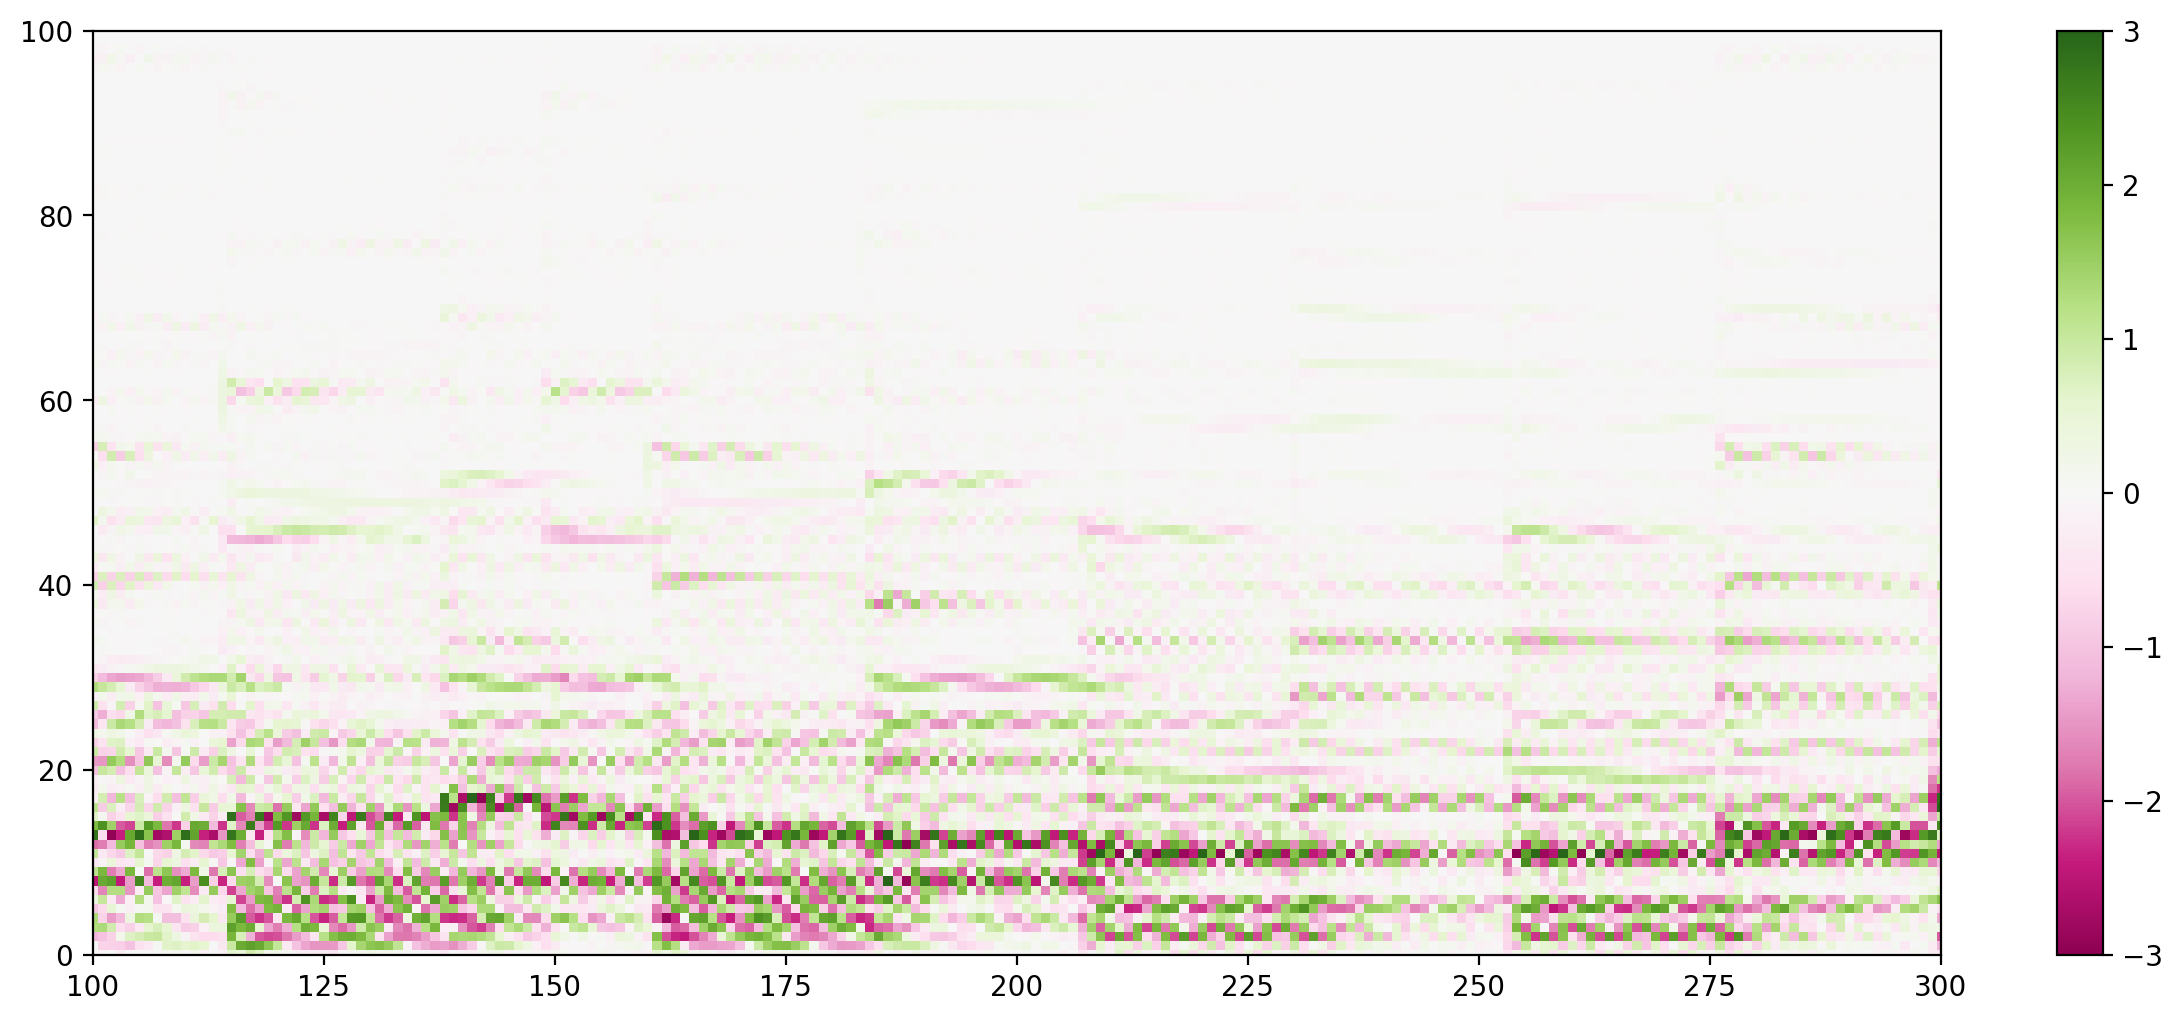

In [57]:
x = wav_to_tf('piano.wav')
X = mdct(x)
X = X - tf.math.reduce_mean(X)
X = X/tf.math.reduce_std(X)
y = imdct(X)
play(x)
play(y)
show(slog(X))

Sharifi et al "Estimation of Shape Parameter for Generalized Gaussian Distributions in Subband Decompositions of Video"

Exact relation between variance, mean of the absolute values, and shape parameter:

$$r(\gamma) = \frac{\sigma_X^2}{E^2[|X|]} = \frac{\Gamma(1/\gamma)\Gamma(3/\gamma)
}{\Gamma(2/\gamma)}$$

Procedure to fit GGD parameters:

1. Compute the sample mean $\hat{\mu}_X$
2. Compute the sample standard deviation $\hat{\sigma}_X$
3. Estimate the modified mean of the absolute values $\hat{E}[|X|] = \frac{1}{M} \sum_{i=1}^{M} \left| x_i - \hat{\mu}_X \right|$
4. Estimate the shape parameter $\hat{\gamma}=r^{-1}\left(\frac{\hat{\sigma}^2_X }{\hat{E}^2[|X|}\right)$

In [58]:
Γ = sp.special.gamma

def F(x,μ,σ,γ):
    return sp.stats.gennorm.cdf(x, beta=γ, loc=μ, scale=σ)

def Finv(x,μ,σ,γ):
    return sp.stats.gennorm.ppf(x, beta=γ, loc=μ, scale=σ)

def r(γ):
    return Γ(1/γ)*Γ(3/γ)/Γ(2/γ)

def estimate_GGD(X):
    μ = tf.math.reduce_mean(X)
    σ = tf.math.reduce_std(X)
    E = tf.math.reduce_mean(tf.abs(X - μ))
    ρ = tf.square(σ/E)
    
    γ = sp.optimize.bisect(lambda γ:r(γ)-ρ, 0.3, 1.5,maxiter=50)
    return μ,σ,γ

Show fit for the first three frequency bands

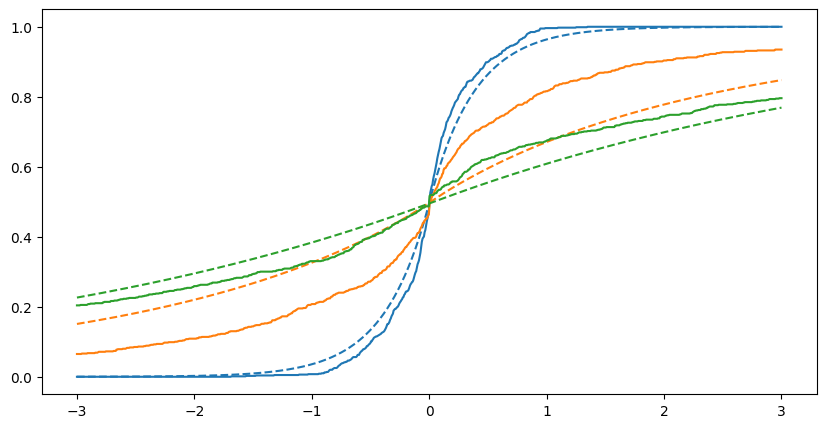

In [59]:
def plot_cdf(bands):
    plt.figure(figsize=(10,5),dpi=100)
    for i_band in range(3):
        band = bands[i_band]
        X_band = tf.reshape(X[:,band],[-1])
        μ,σ,γ = estimate_GGD(X_band)
        z = tf.cast(tf.linspace(-3,3,1000),tf.float32)
        plt.plot(z,F(z,μ,σ,γ),'--',color='C'+str(i_band))
        d = tfp.distributions.Empirical(X_band)
        plt.plot(z,d.cdf(z),'-', color='C'+str(i_band))
plot_cdf([0,1,2])

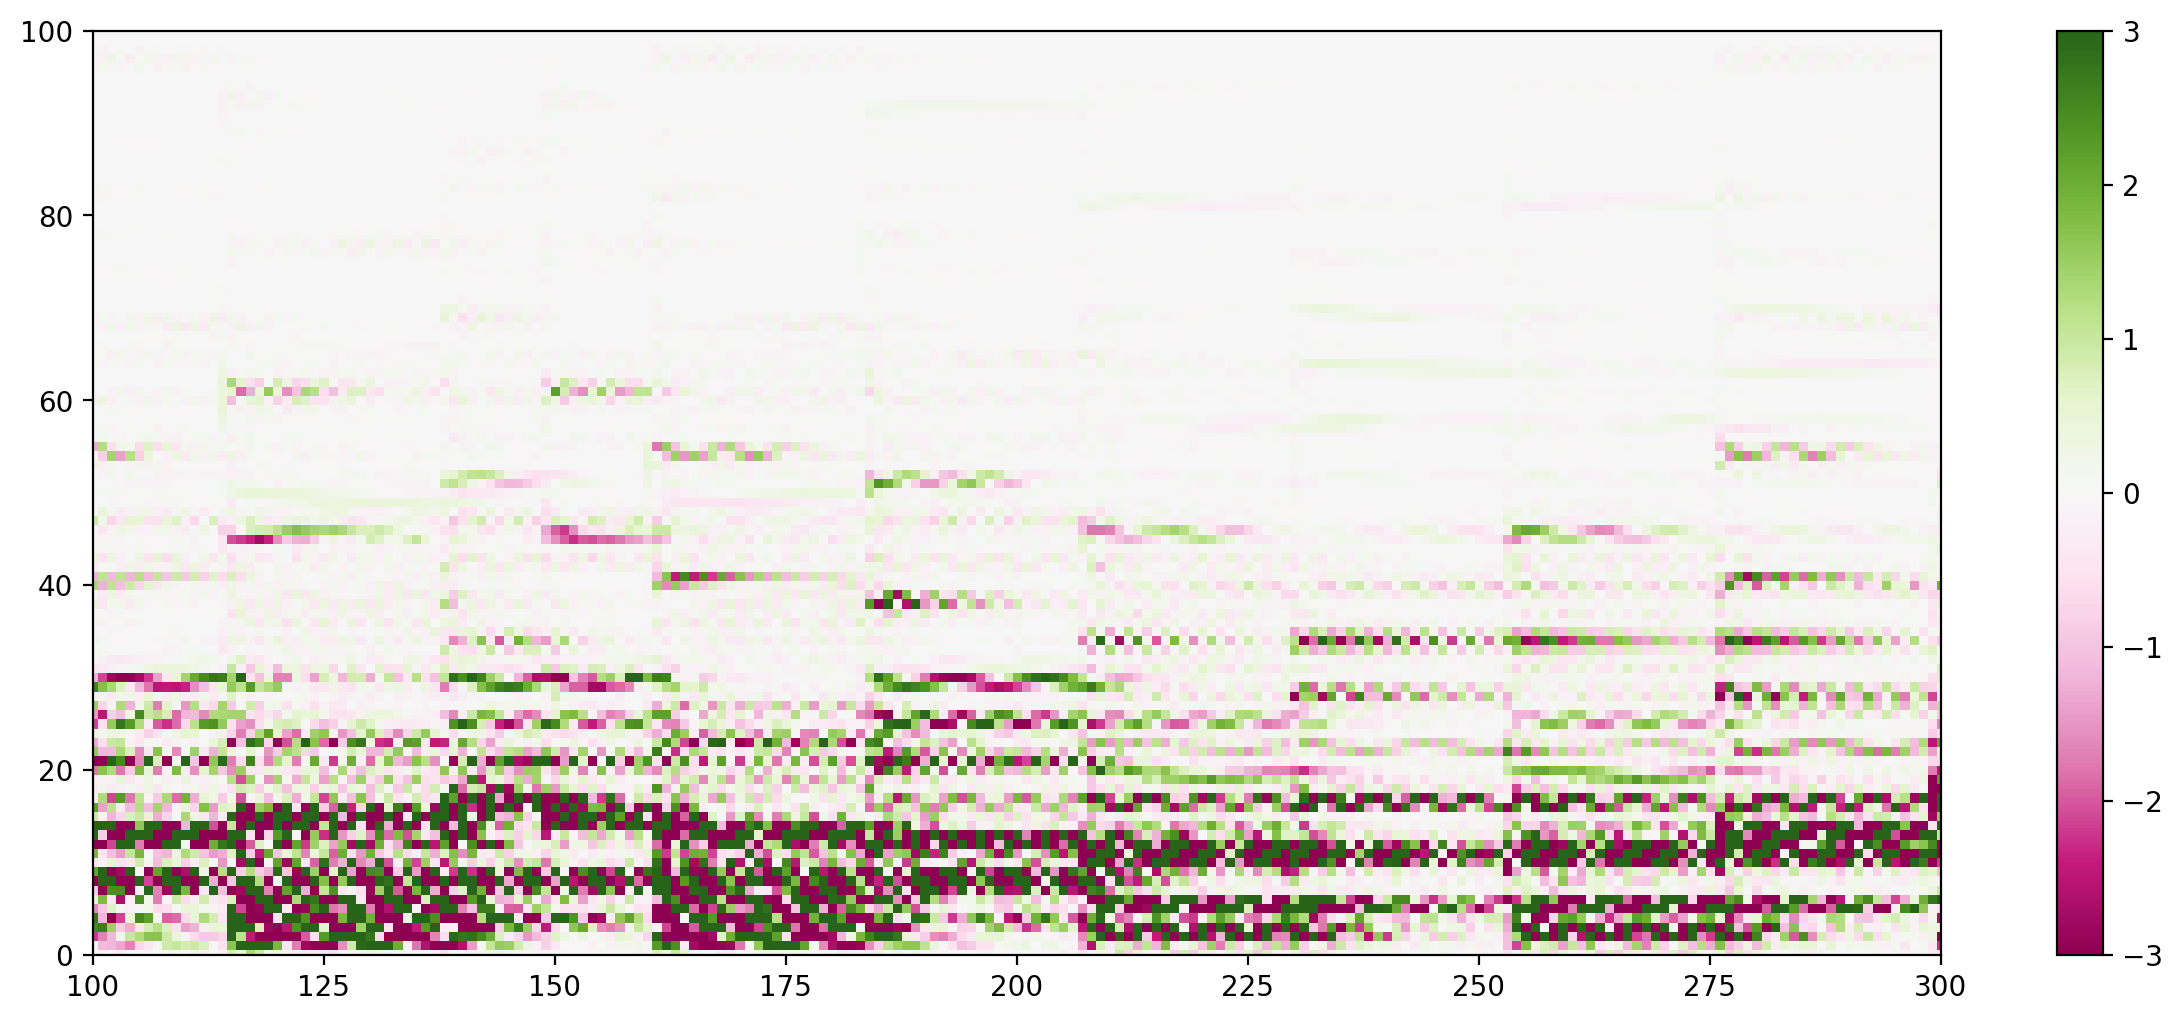

In [94]:
X_flat = tf.reshape(X,[-1])
q = 256
μ,σ,γ = estimate_GGD(X_flat)
Xc = F(X,μ,σ,γ)
Xc = tf.round(q*Xc)
Xc = tf.cast(Xc,tf.uint8)
Xh = Finv(tf.cast(Xc,tf.float32)/q,μ,σ,γ)
show(Xh,clim=(-3,3))

Xh = tf.where(tf.math.is_inf(Xh), tf.ones_like(Xh), Xh)
play(imdct(Xh))

In [120]:
bits = tf.io.encode_jpeg(tf.expand_dims(Xc,axis=2),quality=80)
tf.io.write_file('test.jpeg',bits)
bits = tf.io.read_file('test.jpeg')
Xr = tf.io.decode_jpeg(bits)[:,:,0]

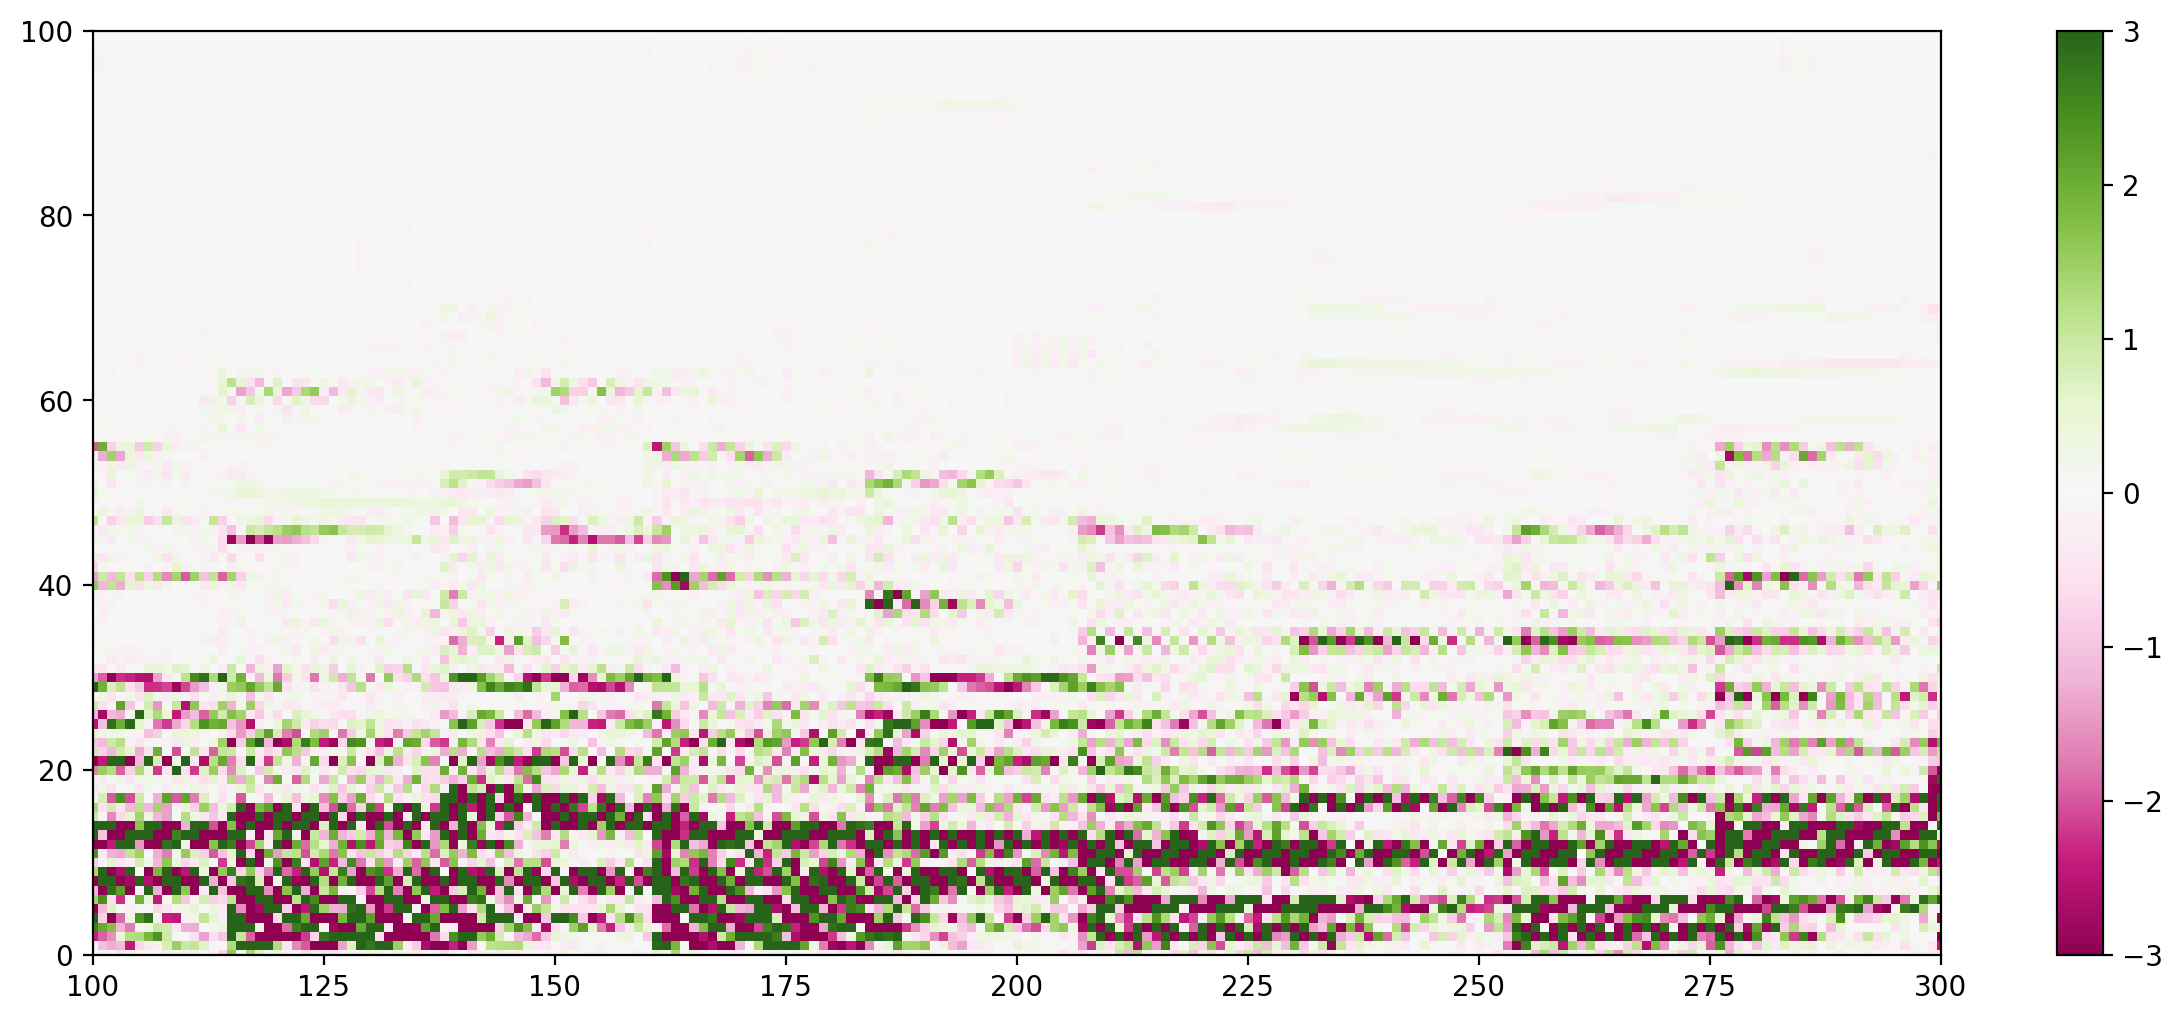

In [121]:
Xh = Finv(tf.cast(Xr,tf.float32)/q,μ,σ,γ)
show(Xh,clim=(-3,3))
Xh = tf.where(tf.math.is_inf(Xh), tf.ones_like(Xh), Xh)
play(imdct(Xh))